In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import mnist
import matplotlib.pyplot as plt

Obtain the MNIST dataset (using `pip install mnist`) and plot a few examples from the training set

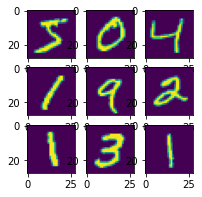

In [15]:
imgs = mnist.train_images()
f,axarr = plt.subplots(3,3)

for idx,ax in enumerate(axarr.ravel()):
    ax.imshow(imgs[idx])

f.set_size_inches(3,3)

Create Two PyTorch models that can take a batch of MNIST images in the form of a flattened vector (N, 768) and output logits for 10 classes

* As a first model use a densely connected feed-forward model with 3 hidden layers of 100 units and ReLU activation
* As a second model use a Convolutional Neural Network with 3 convolutional blocks (convolution, Relu, maxpool) with convolution kernel sizes of 5,3 and 2 and a maxpool kernel size of 2. Followed by a Linear projection layer to the 10 class labels

Report the number of parameters for both models.

In [23]:
make_mlp = lambda Nunits = 100: torch.nn.Sequential(
    torch.nn.Linear(28*28,Nunits),
    torch.nn.ReLU(),
    torch.nn.Linear(Nunits,Nunits),
    torch.nn.ReLU(),
    torch.nn.Linear(Nunits,Nunits),
    torch.nn.ReLU(),
    torch.nn.Linear(Nunits,10)
)

make_cnn = lambda: torch.nn.Sequential(
    torch.nn.Unflatten(-1,(1,28,28)),
    torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2),
    torch.nn.Flatten(),
    torch.nn.Linear(512,10),
)


def count_params(model):
    return sum([p.view(-1).shape[0] for p in model.parameters()])

print(count_params(make_mlp()))
print(count_params(make_cnn()))

99710
9946


Train a Convolutional Neural Network and a MLP on MNIST with 2D Convolutions and Max-Pooling with the Adam optimizer for 1000 steps. and learning rate 1e-3. Track the train and test loss for both models as you train.

In [24]:
def train_step(model,data,target,opt,loss_fn):
    preds = model(data)
    loss = loss_fn(preds,target)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return {'loss': float(loss)}

def eval_fn(model, loss_fn):
    with torch.no_grad():
        train_X, train_y = (
            torch.FloatTensor(mnist.train_images().reshape(-1,28*28)),
            torch.LongTensor(mnist.train_labels())
        )
        train_X, train_y = sample(train_X, train_y,N = 300)

        test_X, test_y = (
            torch.FloatTensor(mnist.test_images().reshape(-1,28*28)),
            torch.LongTensor(mnist.test_labels())
        )
        test_X, test_y = sample(test_X, test_y,N =  300)

        train_loss = loss_fn(model(train_X),train_y)
        test_loss = loss_fn(model(test_X),test_y)
        return {'test_loss': float(test_loss), 'train_loss': float(train_loss)}

def sample(data,target, N):
    idx = np.random.randint(0,len(data),size = (N,))
    return data[idx], target[idx]
    
def train_loop(model, all_data, all_target, config):
    opt = optim.Adam(model.parameters(), 1e-3)
    loss_fn = nn.CrossEntropyLoss()
    evals = []
    for i in range(config['steps']):
        data, target = sample(all_data, all_target,N =  300)
        report = train_step(model, data, target, opt, loss_fn)
        if i % config.get('eval_every',5) == 0: 
            evals.append(eval_fn(model, loss_fn))
        if i % config.get('print_every', 100) == 0: 
            print(f'step: {i} | loss: {report["loss"]}')
    return evals

In [25]:
evals_mlp = train_loop(
    make_mlp(),
    torch.FloatTensor(mnist.train_images().reshape(-1,28*28)),
    torch.LongTensor(mnist.train_labels()),
    config = dict(
        steps = 1001,
        print_every = 50
    )
)

evals_cnn = train_loop(
    make_cnn(),
    torch.FloatTensor(mnist.train_images().reshape(-1,28*28)),
    torch.LongTensor(mnist.train_labels()),
    config = dict(
        steps = 1001,
        print_every = 50
    )
)

step: 0 | loss: 7.116674900054932
step: 50 | loss: 0.2779459059238434
step: 100 | loss: 0.2531156539916992
step: 150 | loss: 0.11256770044565201
step: 200 | loss: 0.070282481610775
step: 250 | loss: 0.11620628088712692
step: 300 | loss: 0.07763269543647766
step: 350 | loss: 0.0917186588048935
step: 400 | loss: 0.12118170410394669
step: 450 | loss: 0.06700999289751053
step: 500 | loss: 0.06040298566222191
step: 550 | loss: 0.14174000918865204
step: 600 | loss: 0.07030513882637024
step: 650 | loss: 0.13204865157604218
step: 700 | loss: 0.0723850280046463
step: 750 | loss: 0.08680879324674606
step: 800 | loss: 0.09771054238080978
step: 850 | loss: 0.059716880321502686
step: 900 | loss: 0.04343457520008087
step: 950 | loss: 0.028527602553367615
step: 1000 | loss: 0.03844517841935158
step: 0 | loss: 12.341312408447266
step: 50 | loss: 0.3613376021385193
step: 100 | loss: 0.2331995964050293
step: 150 | loss: 0.16832707822322845
step: 200 | loss: 0.1343347430229187
step: 250 | loss: 0.1673425

Plot the train and test loss as a function of number of training steps for both the CNN and MLP trainings.
Discuss the results

(0.01, 1.0)

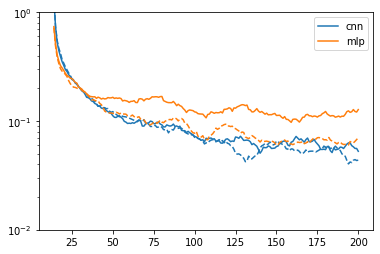

In [30]:
import pandas as pd
def plot_evals(evals,label):
    l = plt.plot(pd.DataFrame([e['train_loss'] for e in evals]).rolling(15).mean(), linestyle='dashed')
    plt.plot(pd.DataFrame([e['test_loss'] for e in evals]).rolling(15).mean(), c = l[0].get_color(), label = label)

plot_evals(evals_cnn, 'cnn')
plot_evals(evals_mlp, 'mlp')
plt.legend()
plt.semilogy()
plt.ylim(1e-2,1e0)

Try to increase the MLP size to match the CNN performance. Report the number of parameters of the model that comes closest to or matches the CNN performance

In [48]:
make_mlp_large = lambda Nunits = 100: torch.nn.Sequential(
    torch.nn.Linear(28*28,Nunits),
    torch.nn.ReLU(),
    torch.nn.Linear(Nunits,Nunits),
    torch.nn.ReLU(),
    torch.nn.Linear(Nunits,Nunits),
    torch.nn.ReLU(),
    torch.nn.Linear(Nunits,Nunits),
    torch.nn.ReLU(),
    torch.nn.Linear(Nunits,Nunits),
    torch.nn.ReLU(),
    torch.nn.Linear(Nunits,Nunits),
    torch.nn.ReLU(),
    torch.nn.Linear(Nunits,Nunits),
    torch.nn.ReLU(),
    torch.nn.Linear(Nunits,10)
)

evals_mlp_matched = train_loop(
    make_mlp_large(1024),
    torch.FloatTensor(mnist.train_images().reshape(-1,28*28)),
    torch.LongTensor(mnist.train_labels()),
    config = dict(
        steps = 1001,
        print_every = 50
    )
)

step: 0 | loss: 2.3018410205841064
step: 50 | loss: 0.44627735018730164
step: 100 | loss: 0.14286525547504425
step: 150 | loss: 0.23499290645122528
step: 200 | loss: 0.11377253383398056
step: 250 | loss: 0.21644246578216553
step: 300 | loss: 0.048796676099300385
step: 350 | loss: 0.052771370857954025
step: 400 | loss: 0.08692071586847305
step: 450 | loss: 0.16374003887176514
step: 500 | loss: 0.06325509399175644
step: 550 | loss: 0.052853237837553024
step: 600 | loss: 0.05367906391620636
step: 650 | loss: 0.08722417056560516
step: 700 | loss: 0.07777438312768936
step: 750 | loss: 0.021597543731331825
step: 800 | loss: 0.07548803836107254
step: 850 | loss: 0.0434061624109745
step: 900 | loss: 0.11191825568675995
step: 950 | loss: 0.04468432441353798
step: 1000 | loss: 0.035379741340875626


(0.01, 1.0)

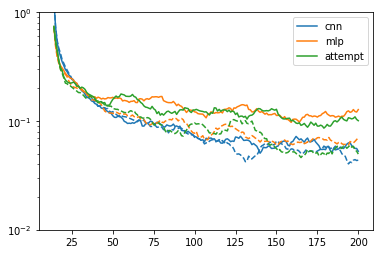

In [49]:
plot_evals(evals_cnn, 'cnn')
plot_evals(evals_mlp, 'mlp')
plot_evals(evals_mlp_matched, 'attempt')
plt.legend()
plt.semilogy()
plt.ylim(1e-2,1e0)